In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import seaborn as sns

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df=pd.read_csv("test.csv")
df['processed_title'] = ' '
df['processed_text'] = ' '
df['processed_label'] = ' '

In [ ]:
df

,Unnamed: 0,title,text,label,processed_title,processed_text,processed_label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,,,
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,,,
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,,,
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,,,
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,,,
...,...,...,...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL,,,
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,,,
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,,,
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL,,,


In [ ]:
def preprocessor(text):
    text_p = "".join([char for char in text if char not in string.punctuation])
    words = word_tokenize(text_p)
    stop_words = stopwords.words('english')
    filtered_words = [word for word in words if word not in stop_words]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in filtered_words]
    return stemmed

In [ ]:
for i in tqdm(range(len(df['text']))):
    temp=preprocessor(df['text'][i])
    res_text=' '.join(item for item in temp)
    df['processed_text'][i] = res_text
    temp=preprocessor(df['title'][i])
    res_title=' '.join(item for item in temp)
    df['processed_title'][i] = res_title
    test=0
    if df['label'][i]=="FAKE":
        test=0
    else:
        test=1
    df['processed_label'][i] = test

  0%|          | 0/6335 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
100

In [ ]:
df

,Unnamed: 0,title,text,label,processed_title,processed_text,processed_label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,you can smell hillari ’ fear,daniel greenfield shillman journal fellow free...,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,watch the exact moment paul ryan commit polit ...,googl pinterest digg linkedin reddit stumbleup...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,kerri go pari gestur sympathi,US secretari state john F kerri said monday st...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,berni support twitter erupt anger dnc We tri warn,— kayde king kaydeek novemb 9 2016 the lesson ...,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,the battl new york whi thi primari matter,it primari day new york frontrunn hillari clin...,1
...,...,...,...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL,state depart say cant find email clinton IT sp...,the state depart told republican nation commit...,1
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,the ‘ P ’ pb should stand ‘ plutocrat ’ ‘ pent...,the ‘ P ’ pb should stand ‘ plutocrat ’ ‘ pent...,0
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,antitrump protest are tool oligarchi inform,antitrump protest are tool oligarchi reform a...,0
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL,In ethiopia obama seek progress peac secur eas...,addi ababa ethiopia —presid obama conven meet ...,1


In [ ]:
df.duplicated(subset={"title"}).value_counts()

False    6256
True       79
dtype: int64

In [ ]:
df1 =  df.drop_duplicates(subset={"title"},keep="first")

In [ ]:
df1.duplicated(subset={"title"}).value_counts()

False    6256
dtype: int64

In [ ]:
df1

,Unnamed: 0,title,text,label,processed_title,processed_text,processed_label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,you can smell hillari ’ fear,daniel greenfield shillman journal fellow free...,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,watch the exact moment paul ryan commit polit ...,googl pinterest digg linkedin reddit stumbleup...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,kerri go pari gestur sympathi,US secretari state john F kerri said monday st...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,berni support twitter erupt anger dnc We tri warn,— kayde king kaydeek novemb 9 2016 the lesson ...,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,the battl new york whi thi primari matter,it primari day new york frontrunn hillari clin...,1
...,...,...,...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL,state depart say cant find email clinton IT sp...,the state depart told republican nation commit...,1
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,the ‘ P ’ pb should stand ‘ plutocrat ’ ‘ pent...,the ‘ P ’ pb should stand ‘ plutocrat ’ ‘ pent...,0
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,antitrump protest are tool oligarchi inform,antitrump protest are tool oligarchi reform a...,0
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL,In ethiopia obama seek progress peac secur eas...,addi ababa ethiopia —presid obama conven meet ...,1


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6256 entries, 0 to 6334
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       6256 non-null   int64 
 1   title            6256 non-null   object
 2   text             6256 non-null   object
 3   label            6256 non-null   object
 4   processed_title  6256 non-null   object
 5   processed_text   6256 non-null   object
 6   processed_label  6256 non-null   object
dtypes: int64(1), object(6)
memory usage: 391.0+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


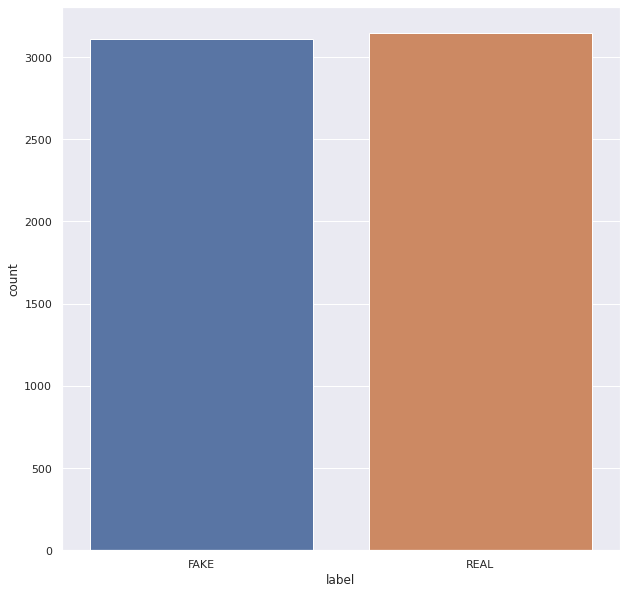

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(df1['label'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


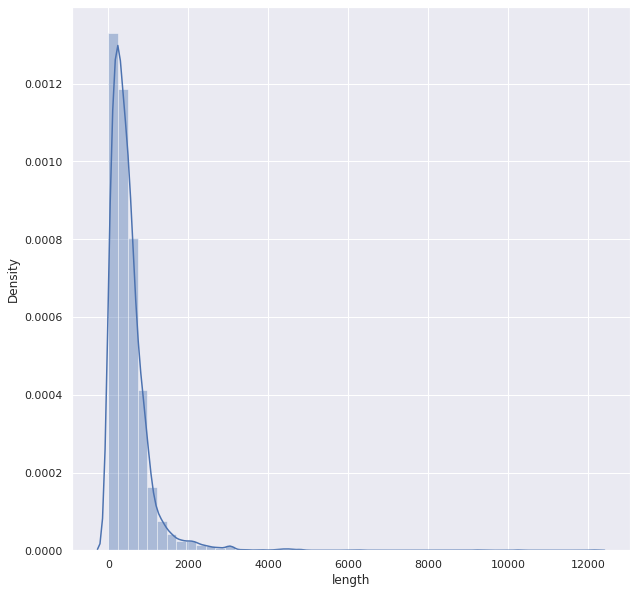

In [ ]:
temp=df1['processed_title']+' '+df1['processed_text']
df1['length']=temp.apply(lambda x:len(x.split(' ')))
sns.distplot(df1['length'])

In [ ]:
df1['length'].describe()

count     6256.000000
mean       496.829444
std        529.336529
min          4.000000
25%        194.750000
50%        388.000000
75%        640.000000
max      12142.000000
Name: length, dtype: float64

In [ ]:
class LSTM_Text_Classifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, embedding_vector_length, max_seq_length, lstm_layers, batch_size=32, num_epochs=3, use_hash=False,
                dropout=None, conv_params=None):
        
        """
        __init__ method: creates the tokenizer for the model and saves all of the parameters
        embedding_vector_length - the length of the word vectors that will be learned by the embedding layer
        max_seq_length - the longest sequence of words that will be taken into account by the classifier (ie. 500 words)
        lstm_layers - a list with the number of LSTMs in each recurrent layer
        batch_size - the batch size used for training the model
        num_epochs - the maximum number of epochs to train for
        use_hash - whether or not to use the hashing trick for word indexing
        dropout - the dropout rate used in the dropout layers of the model
        conv_params - a dictionary with parameters for the convolutional part of the model
        """
        
        self.embedding_vector_length = embedding_vector_length
        self.max_seq_length = max_seq_length
        self.lstm_layer_sizes = lstm_layers
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.use_hashing_trick = use_hash
        if not self.use_hashing_trick:
            self.tokenizer = Tokenizer()
        self.dropout = dropout
        self.conv_params = conv_params
        
    
    def _get_word_index(self, word):
        """
        This function retrieves the index for a given word using the tokenizer.
        """
        
        try:
            return self.tokenizer.word_index[word]
        except:
            return None
        
    def _text_to_int_sequence(self, text):
        "This function converts a string of text into an integer sequence"
        
        seq = [self._get_word_index(word) for word in text_to_word_sequence(text)]
        return [index for index in seq if index]
        
    def fit(self, X, y, validation_data):
        """
        This fit function is analagous to the Scikit-learn fit function used for its estimator API.
        X (array-like) - features (text data)
        y (array-like) - target (class labels)
        validation_data - a tuple with the validation features and targets
        """
        
        all_X = pd.concat([X, validation_data[0]])
        if self.use_hashing_trick:
            all_words = set()
            for text in all_X:
                new_words = set(text_to_word_sequence(text))
                all_words = all_words.union(new_words)
            self.max_vocab = len(all_words)*1.3
            
            for i in range(len(X)):
                X[i] = hashing_trick(X[i], max_vocab, hash_function='md5')
            X_pad = sequence.pad_sequences(X, maxlen=self.max_seq_length)
            
            X_valid = validation_data[0]
            
            for i in range(len(X_valid)):
                X_valid[i] = hashing_trick(X_valid[i], max_vocab, hash_function='md5')
            X_valid_pad = sequence.pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
            
        else:    
            print('Fitting Tokenizer...')
            self.tokenizer.fit_on_texts(all_X)
            self.max_vocab = len(self.tokenizer.word_index) + 20
            X = X.apply(self._text_to_int_sequence)
            X_pad = sequence.pad_sequences(X, maxlen=self.max_seq_length)
        
            X_valid = validation_data[0].apply(self._text_to_int_sequence)
            X_valid_pad = sequence.pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
        
        self.model = Sequential()
        self.model.add(Embedding(self.max_vocab, self.embedding_vector_length, input_length=self.max_seq_length))
            
        if self.conv_params is not None:
            use_pooling = False
            if self.conv_params['pool_size'] is not None:
                use_pooling = True
            
            for i in range(self.conv_params['n_layers']):
                self.model.add(Conv1D(filters=2*(i+1)*self.conv_params['filters'], 
                                      kernel_size=self.conv_params['kernel_size'], 
                                      padding='same', activation='relu'))
                if use_pooling:
                    self.model.add(MaxPooling1D(pool_size=self.conv_params['pool_size']))

            
        if len(self.lstm_layer_sizes) > 1:
            for lstm_layer_size in self.lstm_layer_sizes[:-1]:
                self.model.add(LSTM(lstm_layer_size, return_sequences=True))
                self.model.add(Dropout(self.dropout))
            self.model.add(LSTM(self.lstm_layer_sizes[-1]))
        else:
            self.model.add(LSTM(self.lstm_layer_sizes[0]))
        if self.dropout is not None:
            self.model.add(Dropout(self.dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=1,
                              verbose=2, mode='max')
        
        checkpoint = ModelCheckpoint(filepath='best_model',
                                     monitor='val_accuracy',
                                     mode='max',
                                     save_best_only=True)
        
        callbacks_list = [early_stopping, checkpoint]
        print(self.model.summary())
        
        print('Fitting model...')
        self.model.fit(np.asarray(X_pad).astype(np.float32), np.asarray(y).astype(np.float32), validation_data=(np.asarray(X_valid_pad).astype(np.float32), np.asarray(y_valid).astype(np.float32)), 
                  epochs=self.num_epochs, batch_size=self.batch_size, callbacks=callbacks_list)
        
        
    def predict(self, X):
        """
        This function is analagous to the Scikit-learn predict function used for its estimator API. It first preprocesses the text
        data and converts it into an integer sequence.
        X (array-like) - input text data
        """
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        else:
            X = map(X, self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        
    def predict_classes(self, X):
        """
        This function is a wrapper over the keras predict_classes method.It first preprocesses the text data and converts it into
        an integer sequence.
        """
        
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
        else:
            X = map(X, self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
    
    def predict_proba(self, X):
        """
        This function is a wrapper over the keras predict_proba method.It first preprocesses the text data and converts it into
        an integer sequence.
        """        
        if type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequence(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
        else:
            X = map(X, self._text_to_word_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
    
    def load_model(self, file_path):
        "This function is a wrapper over the Keras load_model function"
        
        self.model = load_model(file_path)
    
    def score(self, X, y):
        "This function is a wrapper over the Scikit-learn score function for its estimator API."
        
        pred = self.predict(X)
        return accuracy_score(y, pred)

In [ ]:
lstm_classifier = LSTM_Text_Classifier(embedding_vector_length=64, max_seq_length=512, dropout=0.1, lstm_layers=[128, 128], batch_size=256, num_epochs=5, use_hash=False,
conv_params={'filters': 128, 
             'kernel_size': 5, 
             'pool_size': 2,
             'n_layers': 3})

In [ ]:
temp=df1['processed_title']+' '+df1['processed_text']
X= df1['processed_text']
y= df1['processed_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
lstm_classifier.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting Tokenizer...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 64)           3557440   
                                                                 
 conv1d_3 (Conv1D)           (None, 512, 256)          82176     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 256, 256)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 256, 512)          655872    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 128, 512)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (Non

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


14/14 [==============================] - 259s 18s/step - loss: 0.6534 - accuracy: 0.6138 - val_loss: 0.5678 - val_accuracy: 0.7329
Epoch 2/5
14/14 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8624 

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


14/14 [==============================] - 251s 18s/step - loss: 0.3565 - accuracy: 0.8624 - val_loss: 0.4063 - val_accuracy: 0.8379
Epoch 3/5
14/14 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.9335 

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


14/14 [==============================] - 247s 18s/step - loss: 0.1730 - accuracy: 0.9335 - val_loss: 0.3649 - val_accuracy: 0.8642
Epoch 4/5
14/14 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9578 

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


14/14 [==============================] - 247s 18s/step - loss: 0.1009 - accuracy: 0.9578 - val_loss: 0.4520 - val_accuracy: 0.8664
Epoch 5/5
14/14 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9760 

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


14/14 [==============================] - 244s 18s/step - loss: 0.0694 - accuracy: 0.9760 - val_loss: 0.5098 - val_accuracy: 0.8801


In [ ]:
lstm_classifier.load_model('best_model')
tp=0
tn=0
fp=0
fn=0
#print(y_valid)
y_pred = np.rint(lstm_classifier.predict(X_valid))
#print(y_pred)
for i in range(len(y_pred)):
    if(y_pred[i]==1):
        if(y_pred[i]==y_valid.to_list()[i]):
            tp+=1
        else:
            fp+=1
    else:
        if(y_pred[i]==y_valid.to_list()[i]):
            tn+=1
        else:
            fn+=1
print(tn,fp,fn,tp)
print(np.reshape([tn,fp,fn,tp],(2,2)))
prec=tp/(tp+fp)
recall=tp/(tp+fn)
print(prec)
print(recall)

385 64 41 386
[[385  64]
 [ 41 386]]
0.8577777777777778
0.9039812646370023


In [ ]:
tp=0
tn=0
fp=0
fn=0

y_pred_test = np.rint(lstm_classifier.predict(X_test))

for i in range(len(y_pred_test)):
    if(y_pred_test[i]==1):
        if(y_pred_test[i]==y_test.to_list()[i]):
            tp+=1
        else:
            fp+=1
    else:
        if(y_pred_test[i]==y_test.to_list()[i]):
            tn+=1
        else:
            fn+=1
print(tn,fp,fn,tp)
print(np.reshape([tn,fp,fn,tp],(2,2)))
prec=tp/(tp+fp)
recall=tp/(tp+fn)
print(prec)
print(recall)

788 125 84 880
[[788 125]
 [ 84 880]]
0.8756218905472637
0.9128630705394191
